# PCA with Pytorch

## 1. PCA with SVD
* Pytorch provides SVD methods and we can apply PCA with GPU by using this.
    * [svd](https://pytorch.org/docs/stable/generated/torch.svd.html)
    * [svd_lowrank](https://pytorch.org/docs/master/generated/torch.svd_lowrank.html)
    
## 2. covariance for SVD
* PCA get its linear relations between variables by using covariance.  
* We apply SVD to covariance matrix and obtain PCA results. 

## 1. PCA with SVD

## 2. covariance from data
* You can find definitions of covariance from this
    * https://en.wikipedia.org/wiki/Covariance
    * https://datascienceschool.net/view-notebook/4cab41c0d9cd4eafaff8a45f590592c5/
* covariane [from here](https://www.google.com/url?sa=i&url=https%3A%2F%2Fbyjus.com%2Fcovariance-formula%2F&psig=AOvVaw3DSk-kUfm1w7pKg2OkDuea&ust=1598791100410000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCJCu8aO3wOsCFQAAAAAdAAAAABAD)  
<img src="images/covariance.png" width="150"> 
* data is usually given as [batch * hidden]  
batch corresponds to different X, Y points and hidden corresponds to different dimensions  
matrix multiplication of (X-X_mean) * (X-X_mean)T gives a matrix M  
each elements M_ij of M, which has sum_k (x_ik - x_mean)*(x_kj - x_mean),  
where i,j : different dimensions and k : different points   

In [4]:
# In pytorch,
def cov(xs):
    nn = xs.size(0)
    mat -= torch.mean(mat, dim=1, keepdim=True)
    matt = mat.t()
    return 1.0/nn * mat.matmul(matt).squeeze()

## 3. PCA transformation matrix
* We can achieve the matrix by using SVD

In [ ]:
def get_eigen_vec(data_in):
    cov_mat = cov(data_in)
    _, _, v_mat = torch.svd(covariance_mat)
    # each row of v_mat is an eigen vectors
    # so inner product of eigen vectors with input data gives 
    # new data in new axis
    return v_mat

## 4. Combining codes

In [6]:
import random
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [87]:
class PCA(nn.Module):
    def __init__(self, data):
        super().__init__()
        dim_hidden = data.size(1)
        self.fc = nn.Linear(dim_hidden, dim_hidden, bias=False)
        self.fc_back = nn.Linear(dim_hidden, dim_hidden, bias=False)
        self.get_eigen_vec(data)
        
    def cov(self, xs):
        nn = xs.size(0)-1
        xs = xs.t()
        xsp = xs - torch.mean(xs, dim=1, keepdim=True)
        xspt = xsp.t()
        return 1.0/nn * xsp.matmul(xspt).squeeze()
    
    def get_eigen_vec(self, data_in):
        cov_mat = self.cov(data_in)
        u_mat, eigen_val, v_mat = torch.svd(cov_mat) # u_mat = v_mat.T
        with torch.no_grad(): # set fc weight as v_mat
            self.fc.weight.copy_(v_mat)
            self.fc_back.weight.copy_(u_mat)
        return u_mat, eigen_val, v_mat
    
    def forward(self, xs):
        return self.fc(xs)
    
    def forward_back(self,zs):
        return self.fc_back(zs)

## Test

### linear pointts

Parameter containing:
tensor([[-0.3154, -0.9489],
        [-0.9489,  0.3154]], requires_grad=True)


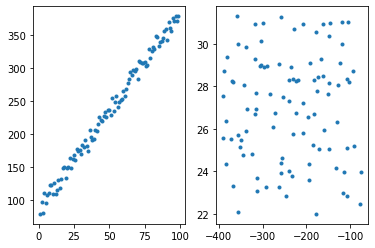

In [117]:
xs = range(1, 100)
ys = [x*3 + random.random()*30 + 70 for x in xs]

xs = torch.tensor(xs, dtype=torch.float)
ys = torch.tensor(ys)
xs = xs.unsqueeze(1)
ys = ys.unsqueeze(1)
data= torch.cat((xs, ys), dim=1)

pca = PCA(data) # 2 for (xs_i, ys_i)
datap = pca(data)
print(pca.fc.weight)

z1s = datap[:,0]
z2s = datap[:,1]

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 
         linestyle='None', marker='.')
plt.subplot(1,2,2)
plt.plot(z1s.detach().numpy(), z2s.detach().numpy(), 
         linestyle='None', marker='.')
plt.show()

In [118]:
u_mat, eigan_val, v_mat = pca.get_eigen_vec(data)

In [119]:
zs0 = torch.zeros(z1s.size()).view(-1,1)
zs1_only = torch.cat((z1s.view(-1,1), zs0),dim=1)
zs2_only = torch.cat((zs0, z2s.view(-1,1)),dim=1) 

In [122]:
xs_new = pca.forward_back(zs1_only)
xs_new1 = xs_new[:,0]
xs_new2 = xs_new[:,1]

xs_newb = pca.forward_back(zs2_only)
xs_new1b = xs_newb[:,0]
xs_new2b = xs_newb[:,1]

xs_new_orig = pca.forward_back(datap)
xs_new_orig1 = xs_new_orig[:,0]
xs_new_orig2 = xs_new_orig[:,1]

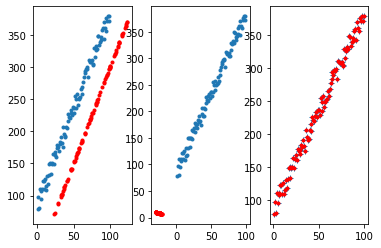

In [127]:
plt.subplot(1,3,1)
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 
        linestyle='None', marker='.')
plt.plot(xs_new1.detach().numpy(), xs_new2.detach().numpy(), 
         linestyle='None', marker='.', color='r')
plt.subplot(1,3,2)
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 
        linestyle='None', marker='.')
plt.plot(xs_new1b.detach().numpy(), xs_new2b.detach().numpy(), 
         linestyle='None', marker='.', color='r')
plt.subplot(1,3,3)
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 
        linestyle='None', marker='+')
plt.plot(xs_new_orig1.detach().numpy(), 
         xs_new_orig2.detach().numpy(), 
         linestyle='None', marker='.', color='r')
plt.show()